# **New Ad Product A/B Testing Results Analysis**
### *Ashanti Jabri*

### **Introduction**

The Company provides a platform where businesses can create advertising ​campaigns​ to increase awareness of their brands or to increase adoption of their products or services. Our current ad product operates in the manner in which advertisers pay us each time a user clicks on their ad.

Each campaign has a ​budget​ (how much money the advertiser is willing to spend during a period of time). An advertiser never has to pay more than their budget, so if we were to spend more than the campaign’s budget, we would not be able to bill the advertiser for the additional spend. This is called ​overspending​. Since The Company only charges advertisers for actual clicks on their ads, the charges can take a while to enter into the system after some (random) delay. For example, suppose a campaign has $10 of the budget remaining and the ad serving systems serves out 1000 ads, expecting 10 of them to generate a click resulting in 1 of revenue each. If however, 20 ads end up generating clicks, we would receive 20 worth of events and not be able to bill the advertiser for 10 of them. Ultimately, this implies The Company has “wasted” 10 worth of ad placements and therefore has incurred a cost.

We have been noticing an increase in overspend on the platform. In an attempt to reduce the amount of overspend, we decided to create a new product where advertisers pay each time their ad appears in a user’s viewport rather than each time it is clicked on -- presumably these engagements would be received at a lower latency. To test the new product, we ran an A/B test. We randomly split the advertisers on the platform. Half of the
advertisers remained on the old product and half received the new product. A week later we have some data and want to determine whether or not the experiment was a success.

### **Hypothesis**
Null hypothesis (H0): The Company's ad campaigns that receive the new product will not reduce overspending compared to campaigns that receive the old product.

Alternative hypothesis (H1): The Company's ad campaigns that receive the new product will reduce overspending compared to campaigns that receive the old product.

### **Methodology**

I'll use a series of methods to determine if we can reject our Null hypothesis:

- We'll conduct in-depth Exploratory Data Analysis to gain insights into our data that could shape or skew our results.

- Check for Randomization, Selection, and Confounding Bias, to ensure that our treatment groups were properly split for testing purposes.

- Conduct the hypothesis test using ANOVA and Kruskal tests.

- Determine Feature Importance using Random Forest Regression.

# Table of contents
1. [Imports](#Imports)
2. [Data Cleaning](#Data_cleaning)
3. [Exploratory Data Analysis (EDA](#EDA)
4. [Hypothesis Testing](#HT)
5. [Feature Importance Using Random Forest Regression and SHAP](#FI)
6. [Conclusions and Recomendations](#CR)

---



# **Imports** <a name="Imports"></a>


---





In [ ]:
!pip install scikit_posthocs
!pip install shap
!pip install pingouin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
import warnings
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scikit_posthocs as sp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap
import pingouin as pg

warnings.filterwarnings("ignore")
mpl.style.use('seaborn-poster')
mpl.style.use('seaborn-whitegrid')
mpl.style.use('fast')

# **Data Cleaning** <a name="Data_cleaning"></a>

Though I was informed that the data would be clean, it's always good practice to do a precursory check to ensure I don't have any nulls, mislabeled columns, wrong datatypes, weird values, etc.

---



In [ ]:
# First glance of the Dataset. The Treatment column is properly labeled, and the dataset seems to be perfectly constructed for examining the A/B test results

df 

,treatment,company_size,campaign_spend,campaign_budget
0,False,small,10.4477,3.9035
1,False,medium,3.7776,1.9872
2,False,medium,46.1880,55.4523
3,False,small,6.6271,6.5136
4,False,small,92.3405,83.1018
...,...,...,...,...
15469,True,small,32.0107,47.5802
15470,True,large,55.2560,44.3909
15471,True,small,94.2496,89.0695
15472,True,medium,2401.8596,3530.2232


In [ ]:
# Checking for Null Values, and Datatypes. Everything seems to be in order, no missing values, and all columns are proper Dtypes. 

df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   treatment        15474 non-null  bool   
 1   company_size     15474 non-null  object 
 2   campaign_spend   15474 non-null  float64
 3   campaign_budget  15474 non-null  float64
dtypes: bool(1), float64(2), object(1)
memory usage: 377.9+ KB


In [ ]:
# Checking the values of MY non-float columns, to ensure that only the values we expect are in those columns. 
# Values such as special characters, or string versions of "NULL" or "N/A" often fly under the radar, so I'm just checking to make sure what I have is what I think we have.

print(df['treatment'].value_counts()) 
print(df['company_size'].value_counts()) 

True     7741
False    7733
Name: treatment, dtype: int64
small     8901
large     5146
medium    1427
Name: company_size, dtype: int64


# **Exploratory Data Analysis (EDA)** <a name="EDA"></a>

---



### Summary Statistics

In [ ]:
# Here I am creating a new column to observe our target variable by subtracting the campaign spend from the budget. 
# Our A/B test was to attempt to optimize for overspend, so we named the column accordingly.

df['over_spend'] = df['campaign_budget'] - df['campaign_spend']

In [ ]:
# Here I'm grouping the Dataset by company size and product type, to get a high level look at some of most blatant differences in our Data.
# This will help guide me towards what I should begin exploring.

df.groupby(['company_size', 'treatment']).describe() 

campaign_spend                ... over_spend              
                                count          mean  ...        75%           max
company_size treatment                               ...                         
large        False             2701.0   5404.567979  ...  -0.317000  4.663582e+05
             True              2445.0  14073.795146  ...  26.882700  4.953671e+06
medium       False              735.0   4473.763322  ...   4.239000  1.713568e+05
             True               692.0   3674.336649  ...  17.471475  1.712557e+05
small        False             4297.0   2947.630134  ...  -0.587800  1.040379e+06
             True              4604.0   1816.811513  ...  -0.042550  1.287388e+05

[6 rows x 24 columns]

In [ ]:
# Here we are simply looking at some statistics for the overspend column specifically.

df[['over_spend', 'treatment']].groupby(['treatment']).describe()

over_spend                             ...                              
               count         mean           std  ...     50%     75%           max
treatment                                        ...                              
False         7733.0   690.977907  18343.184451  ... -2.9582 -0.4319  1.040379e+06
True          7741.0  1047.992765  57417.174307  ... -1.5948  1.7923  4.953671e+06

[2 rows x 8 columns]

In [ ]:
# Finding the campaigns with overspend exceeding 1% of their ad budget in both the control and treatment groups.

print('Old product campaigns with overspend exceeding 1% of their ad budget:')
print(df.loc[df['over_spend'] > (df['campaign_budget'] *0.01)].loc[df['treatment'] == False].count())
print(f'Campaigns with overspend greater than 1% of their budget using the old product represent {np.round((1471/15473)*100,1)}% of total campaigns')

print('')

print('New product campaigns with overspend exceeding 1% of their ad budget:')
print(df.loc[df['over_spend'] > (df['campaign_budget'] *0.01)].loc[df['treatment'] == True].count())
print(f'Campaigns with overspend greater than 1% of their budget using the new product represent {np.round((2010/15473) *100,1)}% of total campaigns')

print('')

print(f'In total, {np.round(((1471+2010)/15473) *100,1)}% of campaigns across treatment groups have overspend greater than 1% of the campaign budget.')

Old product campaigns with overspend exceeding 1% of their ad budget:
treatment          1471
company_size       1471
campaign_spend     1471
campaign_budget    1471
over_spend         1471
dtype: int64
Campaigns with overspend greater than 1% of their budget using the old product represent 9.5% of total campaigns

New product campaigns with overspend exceeding 1% of their ad budget:
treatment          2011
company_size       2011
campaign_spend     2011
campaign_budget    2011
over_spend         2011
dtype: int64
Campaigns with overspend greater than 1% of their budget using the new product represent 13.0% of total campaigns

In total, 22.5% of campaigns across treatment groups have overspend greater than 1% of the campaign budget.


Our initial findings give us some interesting insights. For starters, we can see in the overspend table that on average, the new product is performing better than the old product in reducing overspend by 1.5%.

- Campaigns with overspend greater than 1% of their budget using the new product represent 13.0% of total campaigns.
- Campaigns with overspend greater than 1% of their budget using the old product represent 9.5% of total campaigns
- In total, 22.5% of campaigns across treatment groups have overspend greater than 1% of the campaign budget. 

Let's do a quick overview of our high-level statistics findings based on company size:

**Large Companies**: 

- The mean campaign budget and spend for our large companies using the new product is nearly 3x more than the large companies using the old product.

- The campaigns using the new product saw an increase in overspending by 65%.

- The random selection for this A/B test may have not been random enough.

- More companies with larger budgets could have potentially been picked for the new product group, which could skew our findings. Larger budgets could be indicative of better quality ads, better quality products, more noticeable brands, and several other factors that could allow them to perform better than companies with smaller budgets. However, we could also have some very large outliers that may be causing this large difference.

- The Mean Overspend for the companies using the new product was 6x lower than the companies using the old product. However, as mentioned before, we need to do a little more digging to make sure this information isn't skewed. Larger budgets could be the cause for more attractive ads, which in that case the reduced overspend could be more attributed to the quality of the ads, as opposed to the new product.

**Medium Companies**:

- The Medium companies' budget and spending seem to be more evenly distributed than the larger companies.

- The campaigns using the new product saw a decrease in overspending by 50%.

- Though only marginally so, the mean overspend is larger for the new product group.

- Significantly fewer companies overall in this group when compared to the large and small groups.

**Small Companies**:

- Most of the companies fall in this category.

- The campaigns using the new product saw a decrease in overspending by 30%.

- Significantly larger budgets for small companies using the old product.

- This group is the only group that has a positive mean overspend using the new product, meaning that on average the new product is not performing as intended for smaller companies. This is speculative, however, because outliers may be skewing our data, but this could be a possible cause.

### EDA Visualizations

In [ ]:
# Printing the index of the maximum overspend and the minimum overspend. This may be indicative to outliers, but could also provide valuable insights into our data.

print(df['over_spend'].idxmin())
print(df['over_spend'].idxmax())

# Diplaying the rows with the minimum and maximum overspend. Here we see that they both belong to the New product group and are both large companies.
# Important to note that they both have a similar campaign budget. The differences then could possibly be attributed to other factors regarding their ad, i.e. type of product, type of ad, etc.

df.loc[[12712, 12658]]

12712
12658


,treatment,company_size,campaign_spend,campaign_budget,over_spend
12712,True,large,2.066473e+06,1.777883e+06,-2.885902e+05
12658,True,large,5.289217e+06,1.024289e+07,4.953671e+06


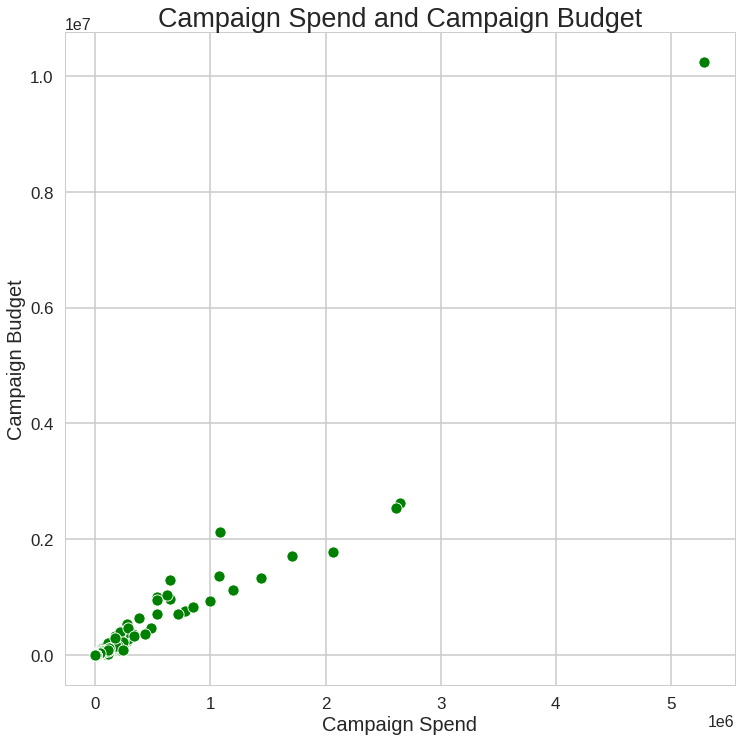

In [ ]:
# Plotting the relationship between campaign spend and campaign budget to observe our outliers.

plt.figure(figsize=(12,12))

sns.scatterplot(y = df['campaign_budget'], x = df['campaign_spend'], color='green')
plt.title(label='Campaign Spend and Campaign Budget', size = 27)
plt.xlabel('Campaign Spend', size = 20)
plt.ylabel('Campaign Budget', size = 20)
plt.xticks(size = 17)
plt.yticks(size = 17)


plt.show();

In [ ]:
# Dropping the outlier

df.drop(axis = 0, index = 12658, inplace = True)

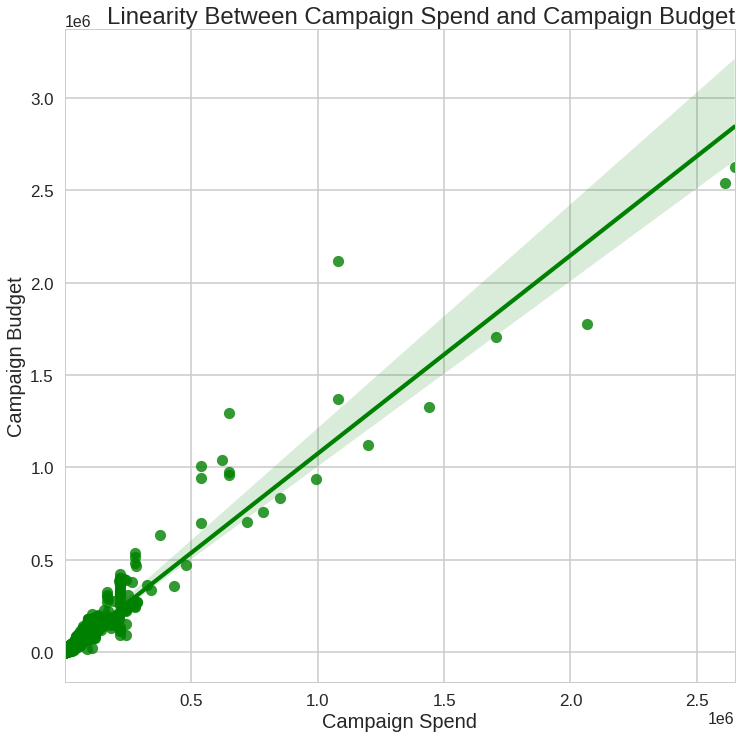

In [ ]:
# Plotting the relationship between campaign spend and campaign budget to observe without outlier

plt.figure(figsize=(12,12))

sns.regplot(y = df['campaign_budget'], x = df['campaign_spend'], color='green')
plt.title(label='Linearity Between Campaign Spend and Campaign Budget', size = 24, loc = 'right')
plt.xlabel('Campaign Spend', size = 20)
plt.ylabel('Campaign Budget', size = 20)
plt.xticks(size = 17)
plt.yticks(size = 17)


plt.show();

We can observe a very clear outlier here, the same one we found before on row 12658. We'll remove it for now, because it's skewing our data dramatically. It had the least amount of overspend, but it also had the highest budget. However, I suggest looking further into this company, and their practices, their ad format, etc. It could be indicative of a new trend that we may be able to take advantage of to help other companies ad campaigns, and with their large ad budget, they're a company we want to maintain a strong relationship with as well.

We can also observe from the graphs something very obvious and intuitive; there is a linear relationship between campaign spend and campaign budget. That is to say that the more money the company allocates towards advertising, the more they end up spending. Common sense observation of course, but worth noting nonetheless. This information can prove vital if we decide to use this data for predictive modeling, using these two columns as possible features to determine an ad campaign's success and possible overspend.

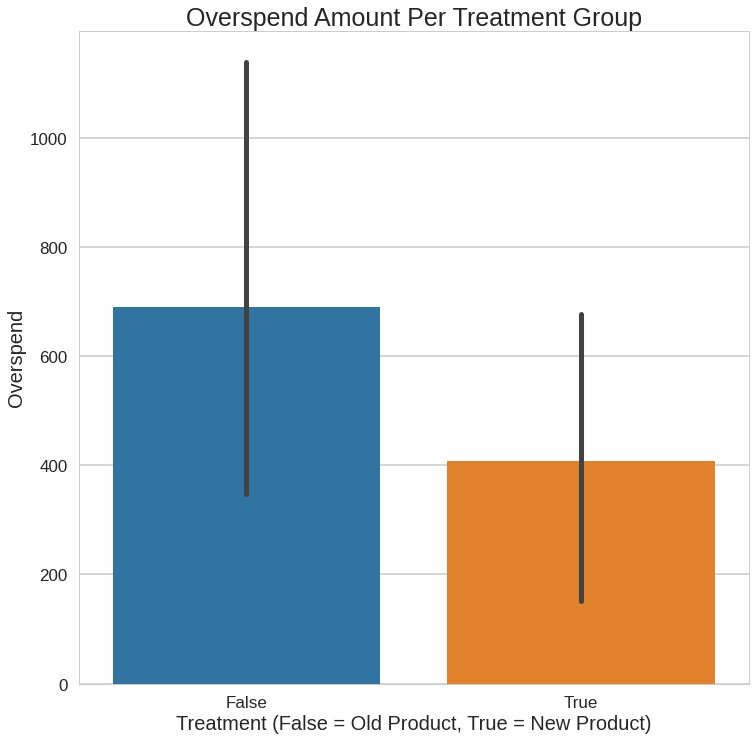

In [ ]:
# Plotting the overspend amount per treatment group.

plt.figure(figsize=(12,12))

sns.barplot(y = df['over_spend'], x = df['treatment'])
plt.title(label='Overspend Amount Per Treatment Group', size = 25)
plt.xlabel('Treatment (False = Old Product, True = New Product)', size = 20)
plt.ylabel('Overspend', size = 20)
plt.xticks(size = 17)
plt.yticks(size = 17)

plt.show();

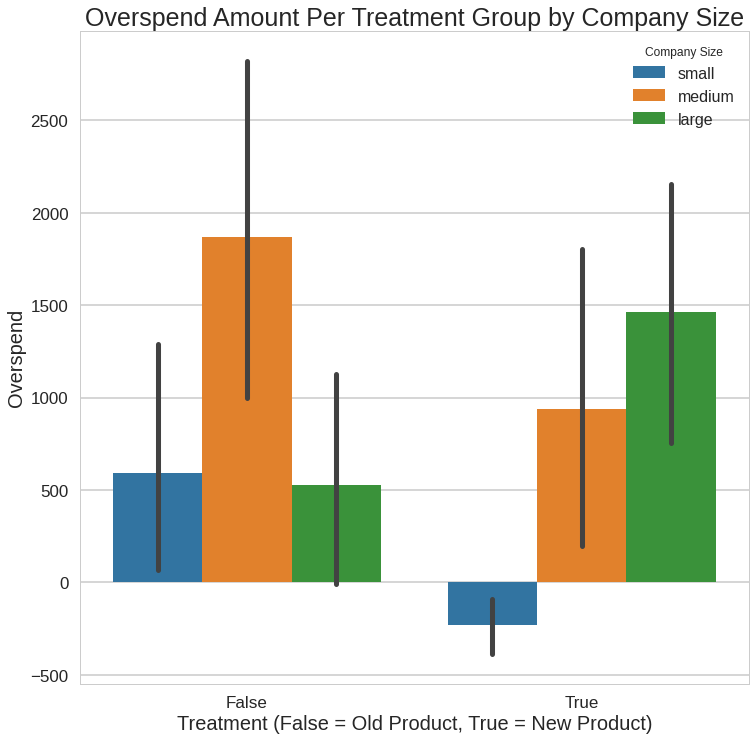

In [ ]:
# Plotting the Overspend amount per treatment group by company size

plt.figure(figsize=(12,12))

sns.barplot(y = df['over_spend'], x = df['treatment'], hue = df['company_size'])
plt.title(label='Overspend Amount Per Treatment Group by Company Size', size = 25)
plt.xlabel('Treatment (False = Old Product, True = New Product)', size = 20)
plt.ylabel('Overspend', size = 20)
plt.xticks(size = 17)
plt.yticks(size = 17)
plt.legend(title = 'Company Size',title_fontsize='large')

plt.show();

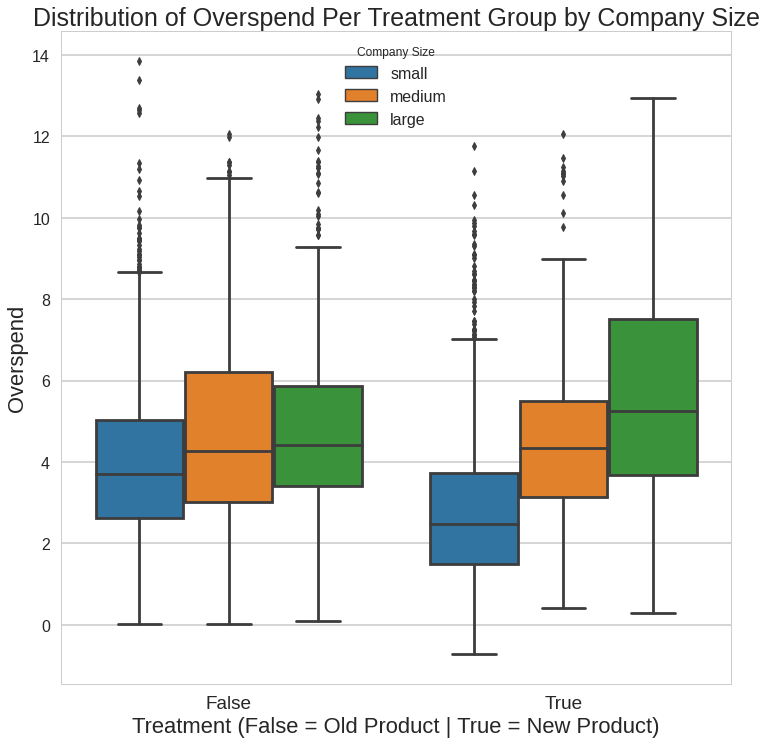

In [ ]:
# Plotting the distribution of the overspend amount per treatment group by company size
# I took the log values of our over_spend column in order to observe our distributions

plt.figure(figsize=(12,12))

sns.boxplot(y = np.log(df['over_spend']), x = df['treatment'], hue = df['company_size'])
plt.title(label='Distribution of Overspend Per Treatment Group by Company Size', size = 25)
plt.xlabel('Treatment (False = Old Product | True = New Product)', size = 22)
plt.ylabel('Overspend', size = 22)
plt.xticks(size = 19)

plt.legend(title = 'Company Size',title_fontsize='large')

plt.show();

From the above three graphs, we can see clearly that there is a significant improvement in reducing overspend with the new product. The new product seems to be having the desired effect, and with some fine-tuning can potentially be used to maximize ad revenue and reduce overspending reliably. However, this is largely dependent on company size, among other factors that we can't observe with our limited dataset. Here are some key takeaways from the above visualizations:

- In regards to total numbers for all companies combined, the new product largely reduced ad overspend when compared to the old product.

- The new product worked especially well for small companies, however, the reason is still not clear. It seems as though maybe the ads may not have run their full course, or because of the lower budgets associated with smaller companies, the margin of error was lower. It's not entirely clear, but with more data, we could dig deeper and uncover some insights.

- The new product performed great in the medium company group as well. The large bulk of overspending is concentrated in the medium company old product group. That is also the fewest amount of companies in our dataset, so this could be due to a lack of variability in our data thus giving us skewed results. Nonetheless, from what we can observe, the new product reduced overspending by more than half in the medium company group.

- The large company group is the most interesting. Overspending increased by half with the introduction of the new product. As we discovered above, the larger companies have larger advertising budgets, meaning they can run their ads longer, more frequently, and in front of more people. I assume that the increase in overspending is in part due to the sheer number of impressions generated far surpasses our current system's ability to pull the ads before overspending occurs. This is speculative, however highly plausible, and is worth looking into further.

# **Hypothesis Testing** <a name="HT"></a>

---

### Randomization, Selection, and Confounding Bias

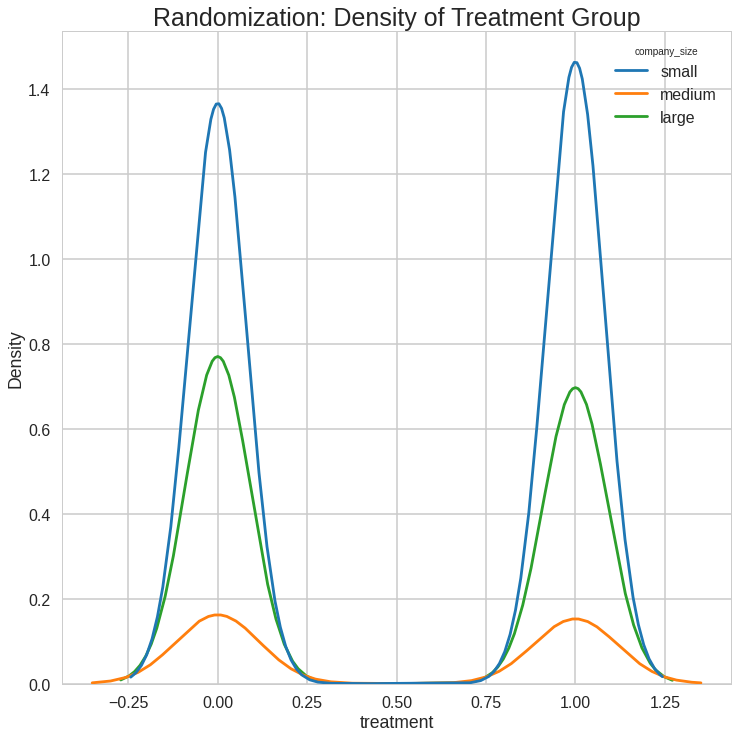

In [ ]:
#KDE Density chart to ensure the the A/B test treatment group selections were random and that there is no overlap between the two groups.

plt.figure(figsize=(12,12))
sns.kdeplot(df['treatment'], hue=df['company_size'])
plt.title(label='Randomization: Density of Treatment Group', size = 25)

plt.show();

Our Density plot above shows that there was indeed random selection when picking the campaigns for the A/B, and there appear to be no signs of confounding bias.

### ANOVA One Way and Kruskal Test for Statistical Signifigance

In [ ]:
# Our confidence interval is 95% and so our alpha is 0.05%. Our p value must be lower than this in order to reject the null hypothesis.
# We first run our signifigance test to determine if we can reject our Null Hypothesis, which in this case is "The new product does not reduce overspending compared to the old prodcut".

df1 = df.loc[df['treatment'] == True, "over_spend"]
df2 = df.loc[df['treatment'] == False, "over_spend"]

print(stats.f_oneway(df1, df2))
print(stats.kruskal(df1, df2))

F_onewayResult(statistic=1.3350027854205826, pvalue=0.24793500729602191)
KruskalResult(statistic=253.73955310454176, pvalue=3.9738097222477247e-57)


In [ ]:
# Observing our Post-Hoc Kruskal Results. Here we can clearly see the differences, further justifying our rejection of the Null hypothesis.

krus = sp.posthoc_conover(df, val_col='over_spend', group_col='treatment', p_adjust = 'holm')
krus

,False,True
False,1.000000e+00,1.399661e-57
True,1.399661e-57,1.000000e+00


Our first result from the one-way ANOVA did not reject the null hypothesis, likely due to the lack of homoscedasticity and abnormal distribution of our samples. The Kruskal test however rejects the null hypothesis and posits that there is a significant difference between the medians of our samples. We can now say conclusively that there is evidence that our New Product has had a statistically significant effect on our overspending. We have observed in our Exploratory Data Analysis that this effect has been a reduction in total overspending. However, this still does not give us the full picture of the effectiveness of the product, only that the product is making a difference when coupled with other features. Things to consider here are:

- While it is true that the new product is affecting overspending, is it the most important feature? 

- Exactly how large of a role does company size play in overspending?

- Does a larger budget always equal overspending? 

We'll use a Random Forest Regression model to determine Feature importance, and possibly answer some of these questions.

# **Feature Importance Using Random Forest Regression and SHAP** <a name="FI"></a>

---

In [ ]:
# Instantiating copy of the dataframe for modeling

model_df = df.copy()

In [ ]:
# Mapping categorical columns to integer classes for Modeling

model_df['treatment'] = model_df['treatment'].map({False:0, True:1})
model_df['company_size'] = model_df['company_size'].map({'small':0, 'medium':1, 'large':2})

In [ ]:
# Creating a very simple model in order to determine feature importance.

X = model_df.drop(columns='over_spend')

y = model_df['over_spend']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 808)

rf = RandomForestRegressor(n_estimators=100, max_depth=5)

rf.fit(X_train, y_train)

In [ ]:
# Here we can see our Feature Importances as percentages in relation to Overspend. 
# For example, this table can be interpreted to mean that campaign budget has a 68% effect on Overspending, in relation to our available data.

pd.DataFrame(data = np.round((rf.feature_importances_ )*100,1), index=['treatment', 'company_size', 'campaign_spend', 'campaign_budget'])

,0
treatment,0.8
company_size,2.1
campaign_spend,28.5
campaign_budget,68.6


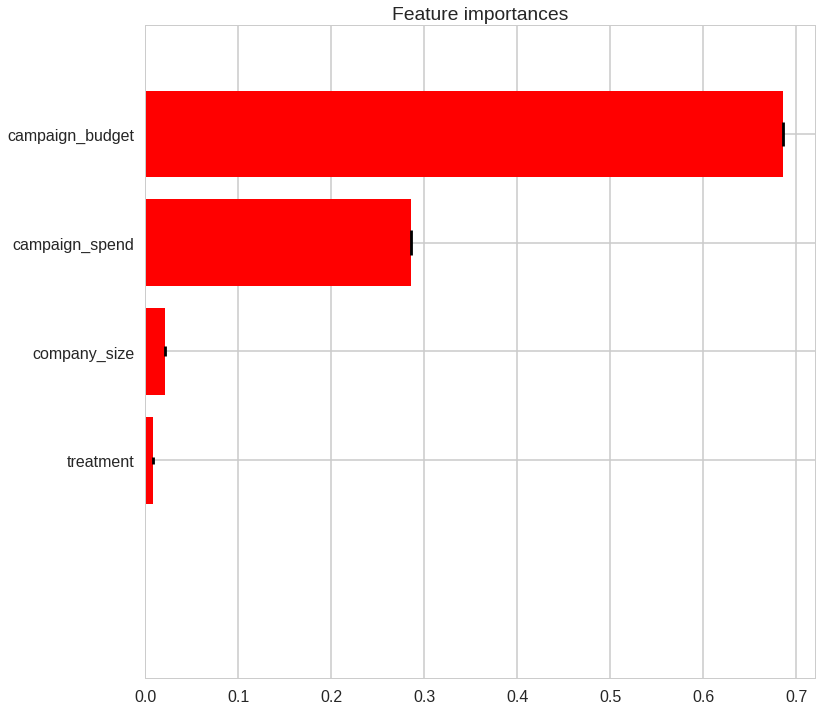

In [ ]:
# Plotting the Feature importance in relation to our target, which in this case is Overspend.

importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_],
 axis=0)

indices = np.argsort(-importances)[::-1]

plt.figure(figsize=(12,12))
plt.title('Feature importances')
plt.barh(range(X.shape[1]), importances[indices], 
 color='r', yerr=std[indices], align='center')
plt.yticks(range(X.shape[1]),X.columns[indices], rotation=0)
plt.ylim([len(importances)-6, len(importances)])
plt.show()

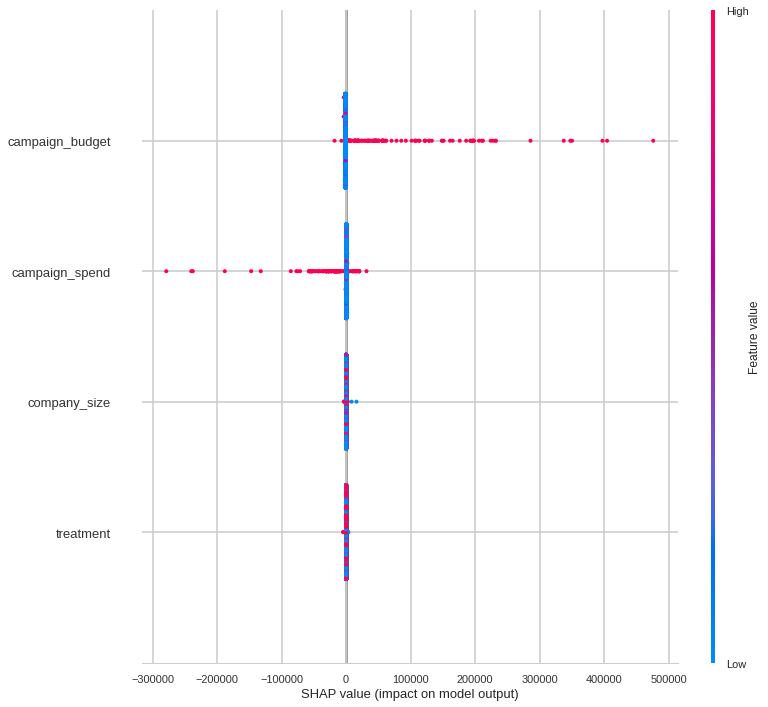

In [ ]:
# Using a graph of our models SHAP (SHapley Additive exPlanations) values, we can observe the direction in which our features effect our target.
# As the dots on the graph move on the X axis, it is representitive of the direction of predictive power. For example, as campaign spend increases, overspending is impacted negativley. And vice-versa for campaign budget.

shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_size=(12.0,12.0))

By observing our Feature importances we can see that though our treatment groups have a marginal effect on overspending, by and large, campaign budget and spend are more related to a campaign's overspending than anything else. The ad product type appears to account for about 0.8% of overspending, while the campaign budget accounts for 68%. 




# **Conclusions and Recomendations** <a name="CR"></a>

---



With the data provided, we can conclusively say that the new product has had a positive effect on reducing overall overspending, largely depending on the company size and campaign budget. I would not recommend implementing the new product on larger companies' ad campaigns. However, for medium and small companies with relatively average budgets, the new product can be beneficial. However, with this being said, I can not give my full support of using this product until the following recommendations are met:

- A longer testing period: A week-long A/B test for a product of this magnitude is much too short. Our data were not normally distributed which is why we had to use a Kruskal Hypothesis test, which lacks in power when compared with the ANOVA test. A longer testing period would give us better results to analyze.

- A more robust Dataset: Our ability to derive meaning from this dataset is limited because of our lack of features. Ad type (video, or picture), industry, video length, desired demographic, etc. These features would have better helped us understand some of the other reasons contributing to overspending, which would have given us a much more concrete conclusion.

- A More Random Selection Criteria: A product manager on the team is concerned that certain advertisers in the treatment group are entering lower budgets because they are wary of the new product. Though we were able to conclude that that was only due to random fluctuations, his question means that companies were privy they were part of the new product group. For an A/B test like this to yield actionable results, it must be conducted blindly. As we have observed, campaign budget is the largest factor in overspend, so if a company is aware they are a part of an experiment group and decide to spend less on ads, it skews our results.

With that being said, our hypothesis test has determined that the new product has a statistical significance in reducing overspend I suggest running further tests for longer periods and then reassessing our results in the future.